In [1]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

class TicTacToe:
    def __init__(self, board_size=3):
        # 0 for empty, 1 for X, -1 for O
        self.board_size = board_size
        self.total_pos = int(board_size ** 2)
        self.reset()

        indices = [i for i in range(0, len(self.board))]
        horizontals = [indices[i:i + self.board_size] for i in range(0, len(indices), self.board_size)]
        verticals = [[i + j * self.board_size for j in range(self.board_size)] for i in range(self.board_size)]
        diagonal_down = [i * self.board_size + i for i in range(self.board_size)]
        diagonal_up = [(i + 1) * (self.board_size - 1) for i in range(self.board_size)]
        lines = horizontals + verticals + [diagonal_down, diagonal_up]
        self.lines = lines


    def is_valid_move(self, position):
        return self.board[position] == 0

    def make_move(self, position):
        if not self.is_valid_move(position):
            return False
        self.board[position] = self.current_player
        self.turns += 1
        return True

    def change_turn(self):
        self.current_player *= -1

    def check_winner(self):
        # Horizontal, vertical, and diagonal checks
        for line in self.lines:
            if all(self.board[i] == self.board[line[0]] and self.board[i] != 0 for i in line):
                self.game_over = self.game_won = True
                return True
        # for a, b, c in self.lines:
        #     if self.board[a] == self.board[b] == self.board[c] and self.board[a] != 0:
        #         return True
        return False

    def get_empty_positions(self):
        empty_pos = [i for i, x in enumerate(self.board) if x == 0]
        if not empty_pos:
            self.game_over = True
        return empty_pos

    def reset(self):
        self.board = [0] * self.total_pos
        self.game_won = False
        self.game_over = False
        self.current_player = 1  # X starts first
        self.turns = 0

    def step(self, action):
        self.make_move(action)
        next_state = self.board.copy()
        next_available_actions = self.get_empty_positions()

        reward = 0
        if self.turns >= self.board_size * 2 - 1:  # The earliest a player can win
            if self.check_winner():
                reward = 1
            elif not next_available_actions: # check for tie
                reward = -0.5
        self.change_turn()

        return next_state, next_available_actions, reward


class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        # Separate Q-tables for X and O
        self.q_tables = {1: {}, -1: {}}  # 1 for X, -1 for O
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_q_value(self, player, state, action):
        return self.q_tables[player].get((tuple(state), action), 0)

    def choose_action(self, player, state, available_actions):
        if not available_actions:
            return None
        if random.random() < self.epsilon:
            return random.choice(available_actions)
        qs = [self.get_q_value(player, state, a) for a in available_actions]
        max_q = max(qs)
        return available_actions[qs.index(max_q)]


    def update_q_value(self, player, state, action, reward, next_state, next_available_actions, opponent):
        current_q = self.get_q_value(player, state, action)
        best_opponent_action = max([self.get_q_value(opponent, next_state, a) for a in next_available_actions], default=0)
        self.q_tables[player][(tuple(state), action)] = current_q + self.alpha * (reward - self.gamma * best_opponent_action - current_q)


def train_agent(game, agent, episodes=1000):
    for _ in tqdm(range(episodes)):
        game.reset()
        while not game.game_over:
            state_0 = game.board.copy()
            player_0 = game.current_player
            available_actions_0 = game.get_empty_positions()
            action_0 = agent.choose_action(player_0, state_0, available_actions_0)

            if action_0 is not None:
                state_1, available_actions_1, reward_0 = game.step(action_0)

                if game.game_over:
                    agent.update_q_value(player_0, state_0, action_0, reward_0, state_1, available_actions_1, opponent=-player_0)
                    break
                else:
                    player_1 = game.current_player
                    action_1 = agent.choose_action(player_1, state_1, available_actions_1)
                    if action_1 is not None:
                        state_2, available_actions_2, reward_1 = game.step(action_1)

                        # if there's a win we will set reward_0 to -1
                        if game.game_won:
                            reward_0 = -1

                        # do first update
                        agent.update_q_value(player_0, state_0, action_0, reward_0, state_1, available_actions_1, opponent=-player_0)

                        # and second
                        agent.update_q_value(player_1, state_1, action_1, reward_1, state_2, available_actions_2, opponent=-player_1)

            if game.game_over:
                break


def play_against_random(agent, games=100):
    wins = 0
    losses = 0
    ties = 0
    agent.epsilon = 0  # No exploration
    for _ in range(games):
        game = TicTacToe()
        random_player = random.choice([-1, 1])  # Randomly decide who starts first

        while not game.game_over:
            available_actions = game.get_empty_positions()
            if not available_actions:  # No available actions, board is full
                ties += 1
                break

            if game.current_player == random_player:
                # Random player's turn
                action = random.choice(available_actions)
                game.make_move(action)
            else:
                # Agent's turn
                action = agent.choose_action(game.current_player, game.board, available_actions)
                if action is not None:
                    game.make_move(action)
            
            # Check game status
            if game.check_winner():
                if game.current_player != random_player:
                    wins += 1
                elif game.current_player == random_player:
                    losses += 1
                game.game_over = True

            game.change_turn()

    print(f"Out of {games} games:")
    print(f"Wins: {wins}")
    print(f"Losses: {losses}")
    print(f"Ties: {ties}")


In [2]:
# Adjust make_move and check_winner accordingly if needed.
game = TicTacToe(board_size=3)
agent = QLearningAgent(alpha=0.02, gamma=0.8, epsilon=0.1)
train_agent(game, agent, episodes=50_000)
play_against_random(agent, games=1000)

100%|██████████| 50000/50000 [00:04<00:00, 10379.31it/s]


Out of 1000 games:
Wins: 805
Losses: 48
Ties: 147


In [27]:
import torch
import torch.optim as optim
import random
from collections import deque
import torch
import torch.nn as nn
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')

class DQN(nn.Module):
    def __init__(self, dim=64, board_size=3):
        super().__init__()
        num_pos = board_size ** 2
        self.fc1 = nn.Linear(num_pos+1, dim)  # Input is 3x3 board flattened to 9
        self.fc2 = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)
        self.fc3 = nn.Linear(dim, dim)
        self.fc4 = nn.Linear(dim, dim)
        self.fc5 = nn.Linear(dim, num_pos)  # Output Q-values for each action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.norm(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


def populate_replay_memory(game, dqn=None, maxlen=20_000, device="cuda"):
    replay_memory = deque(maxlen=maxlen + 1)
    if dqn is not None:
        dqn = dqn.to(device)
    pbar = tqdm(total=maxlen)
    while len(replay_memory) < maxlen - 1:
        game.reset()
        state = game.board.copy()
        while not game.game_over:
            state = game.board
            if dqn is not None:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                    state_tensor = torch.cat([state_tensor, torch.tensor(game.current_player, dtype=torch.float32).to(device)[None]])
                    q_values = dqn(state_tensor).tolist()
                    q_values = torch.tensor([q if i in game.get_empty_positions() else -1e7 for i, q in enumerate(q_values)])
                    action_0 = torch.argmax(q_values).item()
            else:
                action_0 = random.choice(game.get_empty_positions())
            player_0 = game.current_player
            state_1, available_actions_1, reward_0 = game.step(action_0)
            replay_memory.append((state, action_0, reward_0, player_0, state_1, game.game_over))
            pbar.update(1)
            # if game.game_over:
            #     replay_memory.append((state, action_0, reward_0, player_0, state_1, game.game_over))
            # else:
            #     player_1 = game.current_player
            #     # action_1 = agent.choose_action(player_1, state_1, available_actions_1)
            #     action_1 = random.choice(available_actions_1)
            #     # if there's a win we will set reward_0 to -1
            #     if game.game_won:
            #         reward_0 = -1
            #     state_2, available_actions_2, reward_1 = game.step(action_1)
            #     replay_memory.append((state, action_0, reward_0, player_0, state_1, False))
            #     replay_memory.append((state_1, action_1, reward_1, player_1, state_2, game.game_over))
            if game.game_over:
                break

    state, action, reward, player, next_state, done = zip(*replay_memory)
    state = torch.tensor(state, dtype=torch.float32).to(device)
    action = torch.tensor(action, dtype=torch.long).to(device)
    reward = torch.tensor(reward, dtype=torch.float32).to(device)
    player = torch.tensor(player, dtype=torch.float32).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
    done = torch.tensor(done, dtype=torch.float32).to(device)

    return (state, action, reward, player, next_state, done)



# def populate_replay_memory(game, replay_memory, initial_size):
#     while len(replay_memory) < initial_size:
#         state = game.reset()
#         while not game.game_over:
#             action = random.choice(game.get_empty_positions())
#             next_state, reward, done = game.step(action)
#             replay_memory.append((state, action, reward, next_state, done))
#             if done:
#                 break
#             state = next_state


def train_dqn(dqn, data, num_steps=10_000, batch_size=256, gamma=0.9, start_lr=0.0002, end_lr=0.00001, device="cuda"):
    losses = []
    optimizer = optim.Adam(dqn.parameters(), lr=start_lr, weight_decay=0.001, eps=1e-8, betas=(0.9, 0.985))
    loss_fn = torch.nn.MSELoss()
    dqn = dqn.to(device)

    dqn_forward = torch.compile(dqn)

    state, action, reward, player, next_state, done = data

    for step in tqdm(range(num_steps)):
        start_idx = random.randint(0, len(state) - batch_size)
        state_batch = state[start_idx:start_idx+batch_size]
        action_batch = action[start_idx:start_idx+batch_size]
        reward_batch = reward[start_idx:start_idx+batch_size]
        player_batch = player[start_idx:start_idx+batch_size]
        next_state_batch = next_state[start_idx:start_idx+batch_size]
        done_batch = done[start_idx:start_idx+batch_size]

        # Get current Q values for the batch
        state_batch = torch.cat([state_batch, player_batch.unsqueeze(1)], dim=1)
        current_q_values = dqn_forward(state_batch)
        current_q_values = current_q_values.gather(1, action_batch.unsqueeze(1))

        # current_q + self.alpha * (reward - self.gamma * best_opponent_action - current_q)

        # Compute the target Q values
        next_state_batch = torch.cat([next_state_batch, -1 * player_batch.unsqueeze(1)], dim=1)
        max_next_q_values = dqn_forward(next_state_batch).detach().max(1)[0]
        # target_q_values = reward_batch + (1 - done_batch) * gamma * max_next_q_values
        target_q_values = reward_batch - (1 - done_batch) * gamma * max_next_q_values

        # Compute loss
        loss = loss_fn(current_q_values.squeeze(), target_q_values)
        losses.append(loss.item())

        # Optimize the model
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # update lr
        lr = start_lr - (step / num_steps) * (start_lr - end_lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # return minibatch
    return losses



In [39]:
# # Initialize network
# board_size = 4
# dqn = DQN(dim=128, board_size=board_size)

# # Game environment
# game = TicTacToe(board_size=board_size)

data = populate_replay_memory(game, maxlen=100_000)  # Initialize with a certain number of samples

losses = train_dqn(dqn, data)  # Train with a batch size of 32

100011it [00:01, 58644.08it/s]                           
100%|██████████| 10000/10000 [00:41<00:00, 242.50it/s]


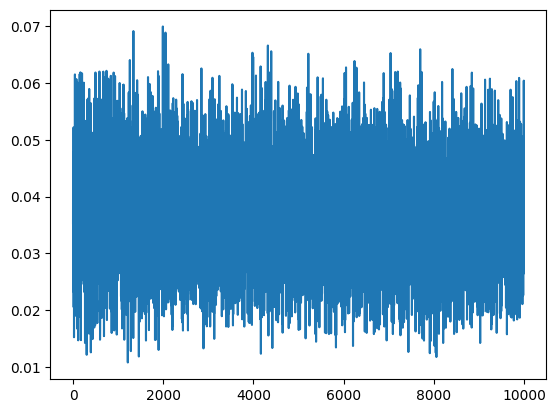

In [40]:
plt.plot(losses)

In [47]:
def play_against_random(dqn, game, games=100):
    wins = 0
    losses = 0
    ties = 0
    agent.epsilon = 0  # No exploration
    dqn = dqn.to("cpu")
    for _ in range(games):
        random_player = random.choice([-1, 1])  # Randomly decide who starts first
        game.reset()

        while not game.game_over:
            available_actions = game.get_empty_positions()
            if not available_actions:  # No available actions, board is full
                ties += 1
                break

            if game.current_player == random_player:
                # Random player's turn
                action = random.choice(available_actions)
                game.make_move(action)
            else:
                # Agent's turn
                state_tensor = torch.tensor(game.board, dtype=torch.float32).unsqueeze(0)
                state_tensor = torch.cat([state_tensor, torch.tensor([game.current_player], dtype=torch.float32).unsqueeze(0)], dim=1)
                with torch.no_grad():
                    action_values = dqn(state_tensor)
                empty_positions = game.get_empty_positions()
                action_values = torch.tensor([action_values[0][i].item() if i in empty_positions else -1e7 for i in range(9)])
                action = action_values.max(0)[1].item()  # Always choose the best action
                if action is not None:
                    game.make_move(action)
            
            # Check game status
            if game.check_winner():
                if game.current_player != random_player:
                    wins += 1
                elif game.current_player == random_player:
                    losses += 1
                game.game_over = True

            game.change_turn()

    print(f"Out of {games} games:")
    print(f"Wins: {wins}")
    print(f"Losses: {losses}")
    print(f"Ties: {ties}")


play_against_random(dqn, game, 100)  # Evaluate the agent over 100 games


Out of 100 games:
Wins: 43
Losses: 57
Ties: 0


In [48]:
import matplotlib.pyplot as plt

def display_board(board):
    if isinstance(board, list):
        side = int(len(board) ** 0.5)
        # using plt
        fig, ax = plt.subplots()
        ax.axis('off')
        ax.add_patch(plt.Rectangle((0, 0), side, side, fill=None))
        # draw lines
        for i in range(1, side):
            ax.plot([i, i], [0, side], 'k')
            ax.plot([0, side], [i, i], 'k')

        size = 40 / (side/3)

        for i, mark in enumerate(board):
            x = (i % side) + 0.5
            y = side-0.5 - (i // side)
            if mark == 1:
                ax.text(x, y, 'X', size=size, ha='center', va='center')
            elif mark == -1:
                ax.text(x, y, 'O', size=size, ha='center', va='center')

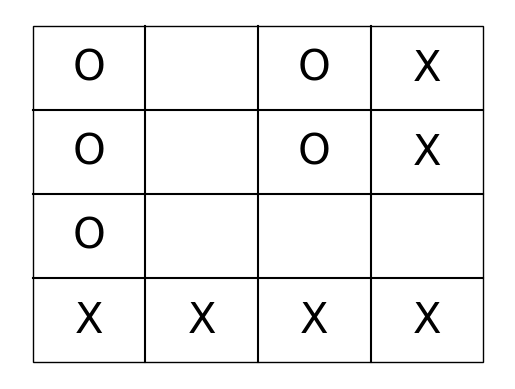

In [49]:
display_board(game.board)

In [52]:
import torch
torch.randperm(10)

tensor([1, 3, 9, 2, 6, 8, 7, 5, 0, 4])

In [65]:
import torch

# Define dimensions
N = 5  # Number of projection matrices
D = 3  # Dimension of each matrix
B = 2 # Batch size

# Create random projection matrices and hidden states
projection_matrices = torch.randn(N, D, D)
projection_matrices[0] = torch.eye(D)  # Set first matrix to identity
hidden_states = torch.randn(1,B * N, D)

print(hidden_states)

# Reshape hidden states to match bmm requirements: [B*N, D, 1]
# hidden_states = hidden_states.view(B, N, D)

# Similarly, reshape projection matrices: [B*N, D, D]
# projection_matrices = projection_matrices.view(N, D, D)

# Perform batch matrix multiplication
result = torch.bmm(hidden_states, projection_matrices)

# Reshape the result back to [B, N, D]
result = result.view(B, N, D)

print(result.shape)  # Should print torch.Size([B, N, D])


tensor([[[ 0.0241, -0.7375, -0.5923],
         [-0.3986,  0.1029, -1.9804],
         [ 1.1608, -0.0799, -0.4477],
         [ 1.3939,  0.3702,  0.4466],
         [ 0.1553,  1.2855, -1.2890],
         [-0.8211,  0.7202, -0.4393],
         [-0.9789,  1.1998, -0.9260],
         [-0.6166, -1.5720,  1.2824],
         [ 0.5714, -0.0491,  0.5766],
         [-0.0563, -0.5754, -2.6745]]])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [1, 3] but got: [5, 3].

In [63]:
import torch

# Define dimensions
N = 5  # Number of projection matrices
D = 3  # Dimension of each matrix
B = 2  # Batch size for hidden states (arbitrary example size)

# Create random projection matrices and hidden states
projection_matrices = torch.randn(N, D, D)  # [N, D, D]
hidden_states = torch.randn(B, N, D)        # [B, N, D]

# Adjust hidden states for matrix multiplication
# hidden_states is already in shape [B, N, D], which is suitable for broadcasting

# Perform batch matrix multiplication using matmul, which supports broadcasting
# Result shape will automatically be [B, N, D]
result = torch.matmul(hidden_states, projection_matrices)

print(result.shape)  # Should print torch.Size([B, N, D])


RuntimeError: The size of tensor a (2) must match the size of tensor b (5) at non-singleton dimension 0